In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from math import isnan
from collections import Counter

In [2]:
attributes = {"part", "hyp", "dyn"}
attr_map = {"part": "Is.Particular", "hyp": "Is.Hypothetical", "dyn": "Is.Dynamic"}
attr_conf = {"part": "Part.Confidence", "hyp": "Hyp.Confidence", "dyn": "Dyn.Confidence"}

data_file = "../../../data/pred_raw_data.tsv"
data = pd.read_csv(data_file, sep="\t")

data['Unique.ID'] = data.apply(lambda x: x['Split'] + " sent_" + str(x['Sentence.ID']) +\
                               "_" + str(x["Span"]), axis=1)
data_test = data[data['Split'] == "test"]
data_dev = data[data['Split'] == "dev"]
data = data[data['Split'] == "train"]
print(len(data), len(data_test), len(data_dev))

26721 9357 9822


### Response distribution

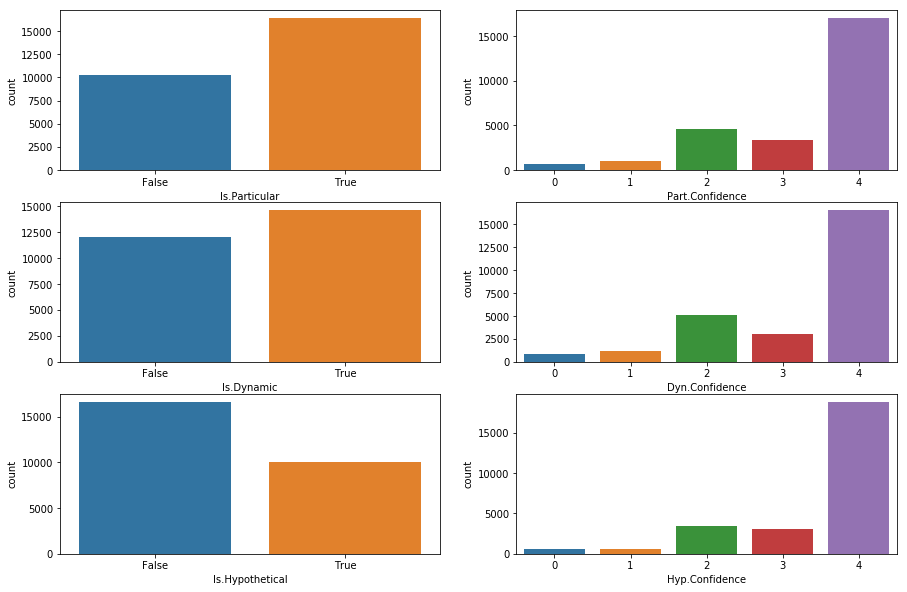

In [3]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.countplot(x='Is.Particular', data=data, ax=axs[0][0])
sns.countplot(x='Part.Confidence', data=data, ax=axs[0][1])
sns.countplot(x='Is.Dynamic', data=data, ax=axs[1][0])
sns.countplot(x='Dyn.Confidence', data=data, ax=axs[1][1])
sns.countplot(x='Is.Hypothetical', data=data, ax=axs[2][0])
sns.countplot(x='Hyp.Confidence', data=data, ax=axs[2][1])

plt.show()

Dyn.Confidence                              0    1     2    3     4
Is.Particular Is.Hypothetical Is.Dynamic                           
False         False           False       365   81   277  147   785
                              True         25  117   580  340  1753
              True            False       101  162   629  301  1934
                              True         55  155   557  422  1512
True          False           False       110  290  1046  415  3721
                              True         56  206  1108  855  4390
              True            False        65  118   395  194   930
                              True         36   89   467  376  1556
                                          Annotator.ID
Is.Particular Is.Hypothetical Is.Dynamic              
False         False           False               1655
                              True                2815
              True            False               3127
                              True           

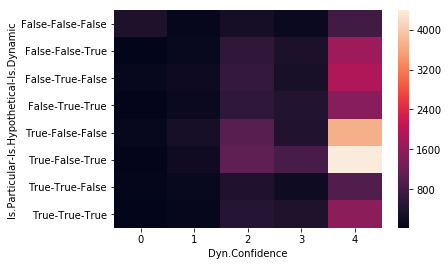

Is.Hypothetical  False  True 
Is.Particular                
False             4470   5828
True             12197   4226 

Is.Hypothetical  False  True 
Is.Dynamic                   
False             7237   4829
True              9430   5225 

Is.Dynamic     False  True 
Is.Particular              
False           4782   5516
True            7284   9139 



In [4]:
print(data.pivot_table(index=['Is.Particular', 'Is.Hypothetical', 'Is.Dynamic'], 
                       columns='Dyn.Confidence', 
                       values='Annotator.ID', aggfunc=len))
print(data.pivot_table(index=['Is.Particular', 'Is.Hypothetical', 'Is.Dynamic'],  
                       values='Annotator.ID', aggfunc=len))
sns.heatmap(data.pivot_table(index=['Is.Particular', 'Is.Hypothetical', 'Is.Dynamic'], 
                             columns='Dyn.Confidence', 
                             values='Annotator.ID', aggfunc=len).fillna(0))
plt.show()

print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Hypothetical',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Dynamic', 
                             columns='Is.Hypothetical',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Dynamic',
                             values='Annotator.ID', aggfunc=len), "\n")

## Inter Annotator agreement

## Raw agreement

In [6]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys
start_agreement, key_start = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Particular')
instant_agreement, key_inst = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Hypothetical')
start_agreement, key_start = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Dynamic')

{3}
####### Raw Count for Is.Particular ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Particular is 1085
Inter-annotator agreement for Is.Particular is 33.13989004276115%


####### Raw Count for Is.Hypothetical ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Hypothetical is 1320
Inter-annotator agreement for Is.Hypothetical is 40.31765424557116%


####### Raw Count for Is.Dynamic ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Dynamic is 1024
Inter-annotator agreement for Is.Dynamic is 31.276725717776422%




## Average of accuracy and kappa for each pair

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    accuracies = []
    lens = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue
        if len(common_set) == 150:
            print(w1, w2)
        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
        lens.append(len(temp1))
    return kappas, accuracies

def rank_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: pearson rank correlation

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    corrs = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        corrs.append(spearman(temp1, temp2)[0])
        accuracies.append(accuracy(temp1, temp2))
        
    return corrs, accuracies

In [ ]:
kappas = {}
corrs = {}
accs = {}
variables = ['hyp', 'part', 'dyn']
variables_ord = ['hyp_conf', 'part_conf', 'dyn_conf']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(data, 'worker_id', 'sent_pred', var)

for var in variables_ord:
    corrs[var], accs[var] = rank_correlation(data, 'worker_id', 'sent_pred', var)

In [ ]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score using builtin function', title="Kappa")
plt.show()
print(np.mean(kappa_data))

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy(raw agreement)', title="Accuracy")
plt.show()
print(np.mean(acc_data))

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()
print(np.mean(corr_data))

# Run mixed effects model in R

## Hyp

In [ ]:
# Enables the %%R magic 
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr); require(lme4)

In [ ]:
%%R -i data -o df_hyp

#Convert to factors
data$part = as.factor(data$part)
data$dyn = as.factor(data$dyn)
data$hyp = as.factor(data$hyp)

#Mixed Effects Model
model = glmer(part ~ 1 + (1|worker_id) + (1|sent_pred) + (1|hit_id), data=data,  family=binomial)

#Model intercepts:
df_hyp = ranef(model)$worker_id
colnames(df_hyp) <- c('intercept')

df_hyp$glmer_intercept_hyp = df_hyp$intercept + 0.8875 #constant added manually
df_hyp$worker_id <- rownames(df_hyp)
print(summary(model))

In [ ]:
df_hyp['glmer_intercept_hyp'] = df_hyp['glmer_intercept_hyp'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_hyp.glmer_intercept_hyp.plot(kind='density')
plt.title("Annotator probability density of saying part = true")
plt.show()

## Part

In [ ]:
%%R -i data -o df_part

#Convert to factors
data$part = as.factor(data$part)
data$dyn = as.factor(data$dyn)
data$hyp = as.factor(data$hyp)

#Mixed Effects Model
model = glmer(part ~ 1 + (1|worker_id) + (1|sent_pred) + (1|hit_id), data=data,  family=binomial)

#Model intercepts:
df_part = ranef(model)$worker_id
colnames(df_part) <- c('intercept')

df_part$glmer_intercept_part = df_part$intercept + 0.8875 #constant added manually
df_part$worker_id <- rownames(df_part)
print(summary(model))

In [ ]:
df_part['glmer_intercept_part'] = df_part['glmer_intercept_part'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_part.glmer_intercept_part.plot(kind='density')
plt.title("Annotator probability density of saying part = true")
plt.show()

## Dynamic

In [ ]:
%%R -i data -o df_dyn

#Convert to factors
data$part = as.factor(data$part)
data$dyn = as.factor(data$dyn)
data$hyp = as.factor(data$hyp)
#Mixed Effects Model
model = glmer(dyn ~ 1 + (1|worker_id) + (1|sent_pred) + (1|hit_id), data=data,  family="binomial")

#Model intercepts:
df_dyn = ranef(model)$worker_id
colnames(df_dyn) <- c('intercept')

df_dyn$glmer_intercept_dyn = df_dyn$intercept + 0.11946 #constant added manually
df_dyn$worker_id <- rownames(df_dyn)

print(summary(model))

In [ ]:
df_dyn['glmer_intercept_dyn'] = df_dyn['glmer_intercept_dyn'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_dyn.glmer_intercept_dyn.plot(kind='density')
plt.title("Annotator probability density of saying dynamic = true")
plt.show()

In [ ]:
def extract_pairs_of_workers1(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict1(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc1(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers1(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict1(data, worker_id, key_var)
    if check_var == "part":
        df = df_part
        int_prob = "glmer_intercept_part"
    elif check_var == "dyn":
        df = df_dyn
        int_prob = "glmer_intercept_dyn"
    else:
        df = df_hyp
        int_prob = "glmer_intercept_hyp"

    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        accuracies.append(accuracy(temp1, temp2))
        # Now for modified kappa calculation
        p_e = (df[df[worker_id] == w1][int_prob][0] * df[df[worker_id] == w2][int_prob][0]) + ((1 - df[df[worker_id] == w1][int_prob][0]) * (1 - df[df[worker_id] == w2][int_prob][0]))
        kappas.append((accuracies[-1] - p_e) / (1 - p_e))
        
    return kappas

In [ ]:
kappas = {}
corrs = {}
accs = {}
variables = ['hyp', 'part', 'dyn']
# variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var] = average_kappa_acc1(data, 'worker_id', 'sent_pred', var)

In [ ]:
kappa_data = pd.DataFrame.from_dict(kappas)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa from mixed effects mode")
plt.show()

print("KAPPA", np.mean(kappa_data))

## Check if average confidence correlates with agreement

In [ ]:
xyz = list(set(raw_data['sent_pred'].values))
raw_data[raw_data['sent_pred'] == "en-ud-train.conllu sent_5978_3"]

In [ ]:
all_list=[]

for question in list(set(data.sent_pred)):
    temp = {}
    temp['sent_pred'] = question
    temp['part_avg_confidence'] = np.mean(list(data[data["sent_pred"] == question]['part_conf']))
    temp['dyn_avg_confidence'] = np.mean(list(data[data["sent_pred"] == question]['dyn_conf']))
    p = sum(list(data[data["sent_pred"] == question]['part'].astype(int))) / 5
    q = sum(list(data[data["sent_pred"] == question]['dyn'].astype(int))) / 5
    temp['part_agreement'] = p * p + (1 - p) * (1 - p)
    temp['dyn_agreement'] = q * q + (1 - q) * (1 - q)
    all_list.append(temp)
analyse_data = pd.DataFrame(all_list)
print(spearman(list(analyse_data['dyn_agreement']), list(analyse_data['dyn_avg_confidence'])))
print(spearman(list(analyse_data['part_agreement']), list(analyse_data['part_avg_confidence'])))

## Random Checking

In [ ]:
cols = ['raw_sentence', 'part', 'part_conf', 'dyn','dyn_conf','hyp','hyp_conf']
# check_data = raw_data[cols]
for sen in xyz:
#     print(check_data[raw_data['sent_pred'] == sen])
    print(str(set(raw_data[raw_data['sent_pred'] == sen]['raw_sentence'].values)), str(set(raw_data[raw_data['sent_pred'] == sen]['pred'].values)))
    print("PART", sum(list(raw_data[raw_data['sent_pred'] == sen]['part'].astype(int)))/5, "CONF", sum(list(raw_data[raw_data['sent_pred'] == sen]['part_conf'].values))/5, "\t\t",
          "HYP", sum(list(raw_data[raw_data['sent_pred'] == sen]['hyp'].astype(int)))/5, "CONF", sum(list(raw_data[raw_data['sent_pred'] == sen]['hyp_conf'].values))/5, "\t\t"
          "DYN", sum(list(raw_data[raw_data['sent_pred'] == sen]['dyn'].astype(int)))/5, "CONF", sum(list(raw_data[raw_data['sent_pred'] == sen]['dyn_conf'].values))/5,"\n\n")